In [11]:
# !pip install flair

In [ ]:
import os
import pandas as pd
import spacy
from flair.models import SequenceTagger
from flair.data import Sentence

sequence_tagger = SequenceTagger.load('ner')
spacy_en_core_web = spacy.load("en_core_web_sm")

def generate_question(subject, relation, object, topic, query_subject=False):
    object_type1 = None
    object_type2 = None
    object_type = None
    discard_flag = False
    convert_dict1 = {
        "PER": "PERSON",
        "LOC": "GPE"
    }

    sentence = Sentence(object)
    sequence_tagger.predict(sentence)
    entities = sentence.get_spans('ner')
    if entities:
        object_type1 = entities[0].tag
        if object_type1 in convert_dict1:
            object_type1 = convert_dict1[object_type1]
        else:
            object_type1 = None

    object_doc = spacy_en_core_web(object)
    if object_doc.ents:
        object_type2 = object_doc.ents[0].label_

    if object_type1:        
        if object_type1 == object_type2:
            object_type = object_type1
        else:
            discard_flag = True
    else:
        if object_type2 not in ["GPE", "PERSON"]:
            object_type = object_type2
        else:
            discard_flag = True
            
    if discard_flag:
        return None

    subject_doc = spacy_en_core_web(relation)
    if subject_doc[-1].tag_ == "IN" and subject_doc[0].tag_ not in ["VBN","VBD","VB","VBZ"]:
        return None
        
    qa = {}
    qa["subject"] = subject
    qa["relation"] = relation
    qa["object"] = object

    object_to_interrogative = {
        "PERSON": "Who",
        "DATE": "When",
    }
    interrogative = object_to_interrogative.get(object_type, "What")

    if subject_doc[0].tag_ == "VBZ":
        qa["question"] = f"{interrogative} does {subject} {relation}?"
        qa["label"] = object
    elif subject_doc[0].tag_ == "VBD":
        qa["question"] = f"{interrogative} did {subject} {relation}?"
        qa["label"] = object
    elif subject_doc[-1].tag_ in ["NN","NNP"]:
        qa["question"] = f"{interrogative} is the {relation} of {subject}?"
        qa["label"] = object
    else:
        return None

    return qa


/mnt/extremessd10tb/borisiuk/miniconda3/envs/triplets/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-08-22 16:08:14,046 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [ ]:
triplets_dir = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/hallu-edit-bench-unfilterd-triplets"

all_rows = []

for fname in os.listdir(triplets_dir):
    if fname.endswith(".csv") and fname != "all_questions.csv":
        fpath = os.path.join(triplets_dir, fname)
        df = pd.read_csv(fpath)

        for _, r in df.iterrows():
            subject, relation, obj = str(r["subjectLabel"]), str(r["relation"]), str(r["objectLabel"])
            qa = generate_question(subject, relation, obj, topic={}, query_subject=False)
            if qa:
                all_rows.append({
                    "file": fname,
                    "question": qa["question"],
                    "answer": qa["label"],
                    "subject": qa["subject"],
                    "relation": qa["relation"],
                    "object": qa["object"]
                })

all_df = pd.DataFrame(all_rows)
out_path = os.path.join(triplets_dir, "all_questions.csv")
all_df.to_csv(out_path, index=False)
print(f"Сохранено {len(all_df)} строк в {out_path}")


Сохранено 55355 строк в /mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/hallu-edit-bench-unfilterd-triplets/all_questions.csv


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import math
from tqdm import tqdm


model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.float16, 
    device_map={"": "cuda:1"}
)


df = pd.read_csv("/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions.csv")


system_prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful assistant.<|eot_id|>"
user_start_tag = "<|start_header_id|>user<|end_header_id|>\n\n"
user_end_tag   = "<|eot_id|>"
asst_start_tag = "<|start_header_id|>assistant<|end_header_id|>\n\n"


def compute_ppl(question, answer):
    # prompt
    prompt = (
        system_prompt
        + user_start_tag + question + user_end_tag
        + asst_start_tag + answer
    )

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda:1")

    # индекс начала ответа (где начинается "answer")
    answer_prefix = (
        system_prompt
        + user_start_tag + question + user_end_tag
        + asst_start_tag
    )
    q_inputs = tokenizer(answer_prefix, return_tensors="pt").to("cuda:1")
    answer_start = q_inputs["input_ids"].shape[1]

    # формируем метки: маскируем вопрос (ставим -100)
    labels = inputs["input_ids"].clone()
    labels[:, :answer_start] = -100

    # forward pass (без генерации)
    with torch.no_grad():
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss.item()

    return math.exp(loss)




ppls = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing PPL"):
    ppl = compute_ppl(row["question"], row["answer"])
    ppls.append(ppl)

df["PPL_Llama3_1-8B_Instruct"] = ppls


out_path = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions_with_ppl.csv"
df.to_csv(out_path, index=False)
print("Файл сохранён:", out_path)

/mnt/extremessd10tb/borisiuk/miniconda3/envs/mmlu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing PPL: 100%|██████████| 55355/55355 [32:23<00:00, 28.48it/s]


✅ Готово, файл сохранён: /mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions_with_ppl.csv


In [8]:
df.head(10)

,file,question,answer,subject,relation,object,PPL_Llama3_1-8B_Instruct
0,technology_programming_language.csv,What does JavaScript has use?,web development,JavaScript,has use,web development,1.705865e+05
1,technology_programming_language.csv,What is the programming paradigm of JavaScript?,aspect-oriented programming,JavaScript,programming paradigm,aspect-oriented programming,3.653560e+04
2,technology_programming_language.csv,What is the programming paradigm of JavaScript?,event-driven programming,JavaScript,programming paradigm,event-driven programming,1.510207e+04
3,technology_programming_language.csv,What is the programming paradigm of JavaScript?,imperative programming,JavaScript,programming paradigm,imperative programming,1.306717e+03
4,technology_programming_language.csv,What is the programming paradigm of JavaScript?,generic programming,JavaScript,programming paradigm,generic programming,1.255563e+06
5,technology_programming_language.csv,What is the programming paradigm of JavaScript?,functional programming,JavaScript,programming paradigm,functional programming,6.556082e+04
6,technology_programming_language.csv,What does JavaScript has use?,computer programming,JavaScript,has use,computer programming,2.508187e+05
7,technology_programming_language.csv,What did JavaScript said to be the same as?,JScript,JavaScript,said to be the same as,JScript,7.515484e+03
8,technology_programming_language.csv,What is the derivative work of Visual Basic?,Visual Basic for Applications,Visual Basic,derivative work,Visual Basic for Applications,6.687721e+00
9,technology_programming_language.csv,What is the developer of Visual Basic?,Microsoft,Visual Basic,developer,Microsoft,9.971189e+01


In [9]:
df

,file,question,answer,subject,relation,object,PPL_Llama3_1-8B_Instruct
0,technology_programming_language.csv,What does JavaScript has use?,web development,JavaScript,has use,web development,1.705865e+05
1,technology_programming_language.csv,What is the programming paradigm of JavaScript?,aspect-oriented programming,JavaScript,programming paradigm,aspect-oriented programming,3.653560e+04
2,technology_programming_language.csv,What is the programming paradigm of JavaScript?,event-driven programming,JavaScript,programming paradigm,event-driven programming,1.510207e+04
3,technology_programming_language.csv,What is the programming paradigm of JavaScript?,imperative programming,JavaScript,programming paradigm,imperative programming,1.306717e+03
4,technology_programming_language.csv,What is the programming paradigm of JavaScript?,generic programming,JavaScript,programming paradigm,generic programming,1.255563e+06
...,...,...,...,...,...,...,...
55350,event_film.csv,What is the location of Moscow Jewish Film Fes...,Moscow,Moscow Jewish Film Festival,location,Moscow,6.443630e+01
55351,event_film.csv,What is the location of Moscow Jewish Film Fes...,Moscow,Moscow Jewish Film Festival,location,Moscow,6.443630e+01
55352,event_film.csv,What is the official language of Huesca Intern...,English,Huesca International Film Festival,official language,English,2.709178e+06
55353,event_film.csv,What is the official language of Huesca Intern...,Spanish,Huesca International Film Festival,official language,Spanish,1.237747e+05


In [40]:
import re
import math
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util

device = "cuda:1"
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map={"": device})
model.eval()
st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

df = pd.read_csv("/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions.csv").fillna({"question":"", "answer":""})

system_prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are terse and fact-only QA assistant. Reply to the question clearly with few-words correct answer.<|eot_id|>"
user_start_tag = "<|start_header_id|>user<|end_header_id|>\n\n"
user_end_tag   = "<|eot_id|>"
asst_start_tag = "<|start_header_id|>assistant<|end_header_id|>\n\n"

def ppl_batch(questions, answers, max_length=2048):
    prefixes = [system_prompt + user_start_tag + q + user_end_tag + asst_start_tag for q in questions]
    prompts = [p + a for p, a in zip(prefixes, answers)]
    with torch.inference_mode():
        enc_pref = tokenizer(prefixes, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        enc_full = tokenizer(prompts,  return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        enc_pref = {k: v.to(device) for k, v in enc_pref.items()}
        enc_full = {k: v.to(device) for k, v in enc_full.items()}
        labels = enc_full["input_ids"].clone()
        for i in range(labels.size(0)):
            labels[i, :enc_pref["input_ids"][i].numel()] = -100
        out = model(**enc_full)
        logits = out.logits[:, :-1, :].float()
        tgt = labels[:, 1:]
        mask = tgt.ne(-100)
        vocab = logits.size(-1)
        loss_flat = F.cross_entropy(logits.reshape(-1, vocab), tgt.reshape(-1), reduction="none", ignore_index=-100)
        loss_tok = loss_flat.view(tgt.size(0), tgt.size(1))
        loss_sum = (loss_tok * mask).sum(dim=1)
        tok_cnt = mask.sum(dim=1).clamp(min=1)
        loss_per_sample = (loss_sum / tok_cnt).cpu().tolist()
    return [math.exp(l) for l in loss_per_sample]

def normalize_words(s):
    return set(re.findall(r"\w+", s.lower()))

def trim_stop(s):
    m = re.search(r"(\.|\n)", s)
    return s[:m.start()] if m else s

def best_gen_for_question(question, answer, N=15, temperature=1.5, top_p=0.95, max_new_tokens=10, max_length=2048):
    prompt = system_prompt + user_start_tag + question + user_end_tag + asst_start_tag
    with torch.inference_mode():
        enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)
        out = model.generate(
            **enc,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            max_new_tokens=max_new_tokens,
            num_return_sequences=N,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    gens = []
    start = enc["input_ids"].shape[1]
    for i in range(out.size(0)):
        txt = tokenizer.decode(out[i][start:], skip_special_tokens=True).strip()
        gens.append(trim_stop(txt))
    aw = normalize_words(answer)
    if len(aw) == 0:
        recalls = [(0.0, g) for g in gens]
    else:
        recalls = [(len(aw & normalize_words(g)) / len(aw), g) for g in gens]
    best_recall, best_gen = max(recalls, key=lambda x: x[0])
    return best_recall, best_gen

BATCH_PPL = 32
ppl_vals = []
for i in tqdm(range(0, len(df), BATCH_PPL), desc="PPL"):
    sl = df.iloc[i:i+BATCH_PPL]
    ppl_vals.extend(ppl_batch(sl["question"].tolist(), sl["answer"].tolist()))
df["PPL_Llama3_1-8B_Instruct"] = ppl_vals

best_gens = []
recalls = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Gen x15"):
    r, g = best_gen_for_question(row["question"], row["answer"], N=15)
    recalls.append(r)
    best_gens.append(g)
df["best_gen_Llama_8b_Instract"] = best_gens
df["gen_recall_Llama_8b_Instract"] = recalls

emb_gen = st.encode(best_gens, convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
emb_ans = st.encode(df["answer"].tolist(), convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
sims = util.cos_sim(emb_gen, emb_ans).diagonal().float().cpu().tolist()
df["bert_sim_Llama_8b_Instract"] = sims

out_path = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions_with_metrics.csv"
df.to_csv(out_path, index=False)
print(out_path)


print("✅ Готово")

Gen x15: 100%|██████████| 55355/55355 [4:55:46<00:00,  3.12it/s]  


/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions_with_metrics.csv
✅ Готово


In [ ]:
import pandas as pd
pd.read_csv("/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions_with_metrics.csv")

,file,question,answer,subject,relation,object,PPL_Llama3_1-8B_Instruct,best_gen_Llama_8b_Instract,gen_recall_Llama_8b_Instract,bert_sim_Llama_8b_Instract
0,technology_programming_language.csv,What does JavaScript has use?,web development,JavaScript,has use,web development,2.089823e+05,Front-end web development,1.000000,0.815780
1,technology_programming_language.csv,What is the programming paradigm of JavaScript?,aspect-oriented programming,JavaScript,programming paradigm,aspect-oriented programming,1.970356e+03,"Multparadigm: Object-oriented, imperative,",0.333333,0.379471
2,technology_programming_language.csv,What is the programming paradigm of JavaScript?,event-driven programming,JavaScript,programming paradigm,event-driven programming,8.839259e+02,Functional and Event-driven,0.666667,0.710449
3,technology_programming_language.csv,What is the programming paradigm of JavaScript?,imperative programming,JavaScript,programming paradigm,imperative programming,1.484698e+02,Functional Programming,0.500000,0.621905
4,technology_programming_language.csv,What is the programming paradigm of JavaScript?,generic programming,JavaScript,programming paradigm,generic programming,6.389426e+03,Prototype-based programming language,0.500000,0.518721
...,...,...,...,...,...,...,...,...,...,...
55350,event_film.csv,What is the location of Moscow Jewish Film Fes...,Moscow,Moscow Jewish Film Festival,location,Moscow,1.528951e+05,Moscow,1.000000,1.000000
55351,event_film.csv,What is the location of Moscow Jewish Film Fes...,Moscow,Moscow Jewish Film Festival,location,Moscow,1.528951e+05,Moscow,1.000000,1.000000
55352,event_film.csv,What is the official language of Huesca Intern...,English,Huesca International Film Festival,official language,English,7.409037e+05,Spanish,0.000000,0.715642
55353,event_film.csv,What is the official language of Huesca Intern...,Spanish,Huesca International Film Festival,official language,Spanish,6.142313e+05,Spanish,1.000000,1.000000


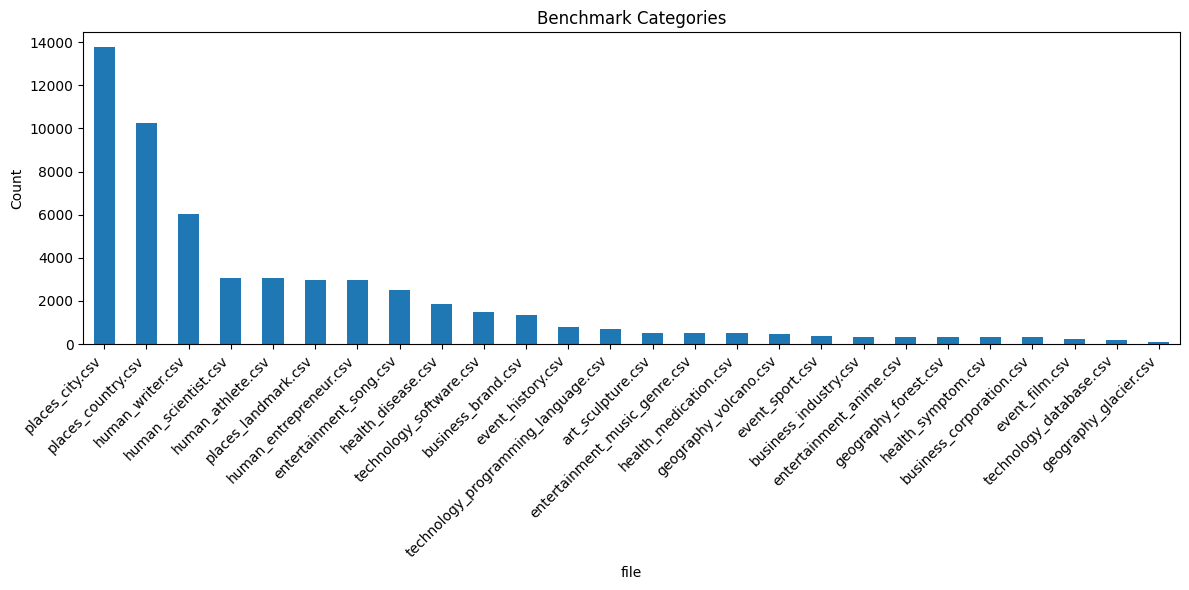

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем датасет
df = pd.read_csv("/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions_with_metrics.csv")

# Считаем количество записей в каждой категории столбца 'file'
counts = df['file'].value_counts()

# Строим гистограмму (столбчатую диаграмму)
plt.figure(figsize=(12, 6))
counts.plot(kind='bar')
plt.title("Benchmark Categories")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [48]:
# Сортируем по колонке в порядке возрастания
df_sorted = df.sort_values(by="PPL_Llama3_1-8B_Instruct", ascending=True)
df_sorted

,file,question,answer,subject,relation,object,PPL_Llama3_1-8B_Instruct,best_gen_Llama_8b_Instract,gen_recall_Llama_8b_Instract,bert_sim_Llama_8b_Instract
17668,entertainment_song.csv,Who is the producer of Another Day in Paradise?,Hugh Padgham,Another Day in Paradise,producer,Hugh Padgham,1.000000e+00,Jimmy Jam and Terry Lewis,0.000000,0.191154
17672,entertainment_song.csv,What is the performer of Boom Boom Pow?,Black Eyed Peas,Boom Boom Pow,performer,Black Eyed Peas,1.000001e+00,The Black Eyed Peas,1.000000,0.978968
17676,entertainment_song.csv,What is the performer of Boom Boom Pow?,Black Eyed Peas,Boom Boom Pow,performer,Black Eyed Peas,1.000001e+00,Black Eyed Peas,1.000000,1.000000
51429,human_scientist.csv,What is the place of birth of Telford Taylor?,Schenectady,Telford Taylor,place of birth,Schenectady,1.000002e+00,"Brockton, Massachusetts, USA",0.000000,0.261164
54116,technology_software.csv,What is the country of Xiaohongshu?,People's Republic of China,Xiaohongshu,country,People's Republic of China,1.000002e+00,China,0.200000,0.595505
...,...,...,...,...,...,...,...,...,...,...
35137,places_country.csv,What is the history of topic of Indonesia?,History of Indonesia,Indonesia,history of topic,History of Indonesia,7.205346e+06,Early Indonesian history: Indonesia inhabited...,0.666667,0.875896
23675,places_landmark.csv,What is the location of Ängsö Castle?,Västerås,Ängsö Castle,location,Västerås,7.870886e+06,"Vansbro, Dalarna, Sweden",0.000000,0.306733
26002,human_entrepreneur.csv,Who is the given name of William Ralph Merton?,William,William Ralph Merton,given name,William,1.016810e+07,Robert,0.000000,0.581730
27288,human_entrepreneur.csv,What is the field of work of John L. Hennessy?,computer,John L. Hennessy,field of work,computer,2.019177e+07,Computer architecture and engineering,1.000000,0.459434


In [67]:
import pandas as pd

# Загружаем датасет
df = pd.read_csv("/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions_with_metrics.csv")

# Сортируем по перплексии
df_sorted = df.sort_values(by="PPL_Llama3_1-8B_Instruct", ascending=True)

# Размер выборки (10%)
n = int(len(df_sorted) * 0.1)

# Выбираем топ-10% с низкой PPL и топ-10% с высокой PPL
low_ppl_high_recall = df_sorted.head(n)
high_ppl_low_recall = df_sorted.tail(n)

# Считаем корреляции
corr_low = low_ppl_high_recall[["PPL_Llama3_1-8B_Instruct", "gen_recall_Llama_8b_Instract"]].corr()
corr_high = high_ppl_low_recall[["PPL_Llama3_1-8B_Instruct", "gen_recall_Llama_8b_Instract"]].corr()

corr_low, corr_high

(                              PPL_Llama3_1-8B_Instruct  \
 PPL_Llama3_1-8B_Instruct                      1.000000   
 gen_recall_Llama_8b_Instract                 -0.019204   
 
                               gen_recall_Llama_8b_Instract  
 PPL_Llama3_1-8B_Instruct                         -0.019204  
 gen_recall_Llama_8b_Instract                      1.000000  ,
                               PPL_Llama3_1-8B_Instruct  \
 PPL_Llama3_1-8B_Instruct                      1.000000   
 gen_recall_Llama_8b_Instract                  0.015691   
 
                               gen_recall_Llama_8b_Instract  
 PPL_Llama3_1-8B_Instruct                          0.015691  
 gen_recall_Llama_8b_Instract                      1.000000  )

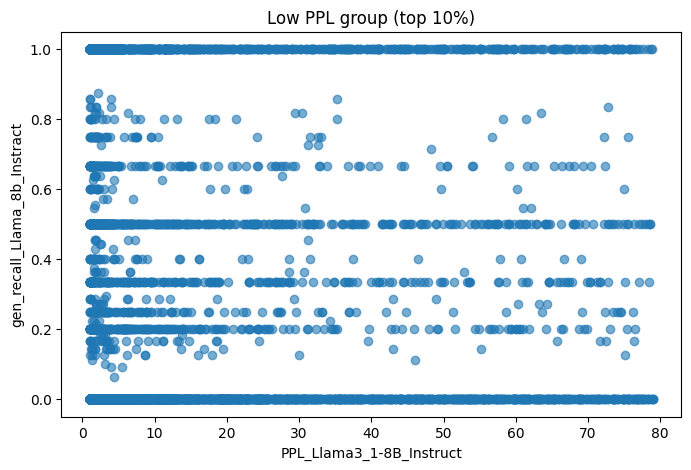

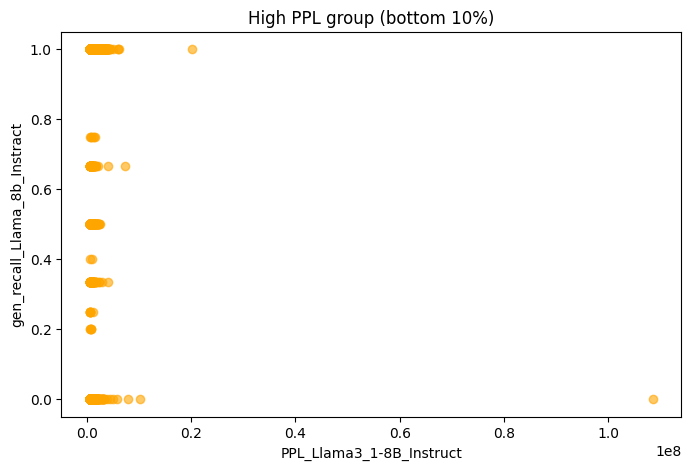

In [68]:
import matplotlib.pyplot as plt

# Scatter для топ-10% с низкой перплексией
plt.figure(figsize=(8, 5))
plt.scatter(low_ppl_high_recall["PPL_Llama3_1-8B_Instruct"], 
            low_ppl_high_recall["gen_recall_Llama_8b_Instract"], alpha=0.6)
plt.title("Low PPL group (top 10%)")
plt.xlabel("PPL_Llama3_1-8B_Instruct")
plt.ylabel("gen_recall_Llama_8b_Instract")
plt.show()

# Scatter для топ-10% с высокой перплексией
plt.figure(figsize=(8, 5))
plt.scatter(high_ppl_low_recall["PPL_Llama3_1-8B_Instruct"], 
            high_ppl_low_recall["gen_recall_Llama_8b_Instract"], alpha=0.6, color="orange")
plt.title("High PPL group (bottom 10%)")
plt.xlabel("PPL_Llama3_1-8B_Instruct")
plt.ylabel("gen_recall_Llama_8b_Instract")
plt.show()



In [1]:
import re
import math
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util

device = "cuda:1"
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map={"": device})
model.eval()
st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

df = pd.read_csv("/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/all_questions.csv").fillna({"question":"", "answer":""})

system_prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are terse and fact-only QA assistant. Reply to the question clearly with few-words correct answer.<|eot_id|>"
user_start_tag = "<|start_header_id|>user<|end_header_id|>\n\n"
user_end_tag   = "<|eot_id|>"
asst_start_tag = "<|start_header_id|>assistant<|end_header_id|>\n\n"

def ppl_batch(questions, answers, max_length=2048):
    prefixes = [system_prompt + user_start_tag + q + user_end_tag + asst_start_tag for q in questions]
    prompts = [p + a for p, a in zip(prefixes, answers)]
    with torch.inference_mode():
        enc_pref = tokenizer(prefixes, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        enc_full = tokenizer(prompts,  return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        enc_pref = {k: v.to(device) for k, v in enc_pref.items()}
        enc_full = {k: v.to(device) for k, v in enc_full.items()}
        labels = enc_full["input_ids"].clone()
        for i in range(labels.size(0)):
            labels[i, :enc_pref["input_ids"][i].numel()] = -100
        out = model(**enc_full)
        logits = out.logits[:, :-1, :].float()
        tgt = labels[:, 1:]
        mask = tgt.ne(-100)
        vocab = logits.size(-1)
        loss_flat = F.cross_entropy(logits.reshape(-1, vocab), tgt.reshape(-1), reduction="none", ignore_index=-100)
        loss_tok = loss_flat.view(tgt.size(0), tgt.size(1))
        loss_sum = (loss_tok * mask).sum(dim=1)
        tok_cnt = mask.sum(dim=1).clamp(min=1)
        loss_per_sample = (loss_sum / tok_cnt).cpu().tolist()
    return [math.exp(l) for l in loss_per_sample]

def normalize_words(s):
    return set(re.findall(r"\w+", s.lower()))

def trim_stop(s):
    m = re.search(r"(\.|\n)", s)
    return s[:m.start()] if m else s

def best_gen_for_question(question, answer, N=15, temperature=1.5, top_p=0.95, max_new_tokens=10, max_length=2048):
    prompt = system_prompt + user_start_tag + question + user_end_tag + asst_start_tag
    with torch.inference_mode():
        enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)
        out = model.generate(
            **enc,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            max_new_tokens=max_new_tokens,
            num_return_sequences=N,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    gens = []
    start = enc["input_ids"].shape[1]
    for i in range(out.size(0)):
        txt = tokenizer.decode(out[i][start:], skip_special_tokens=True).strip()
        gens.append(trim_stop(txt))
    aw = normalize_words(answer)
    if len(aw) == 0:
        recalls = [(0.0, g) for g in gens]
    else:
        recalls = [(len(aw & normalize_words(g)) / len(aw), g) for g in gens]
    best_recall, best_gen = max(recalls, key=lambda x: x[0])
    return best_recall, best_gen

BATCH_PPL = 32
ppl_vals = []
for i in tqdm(range(0, len(df), BATCH_PPL), desc="PPL"):
    sl = df.iloc[i:i+BATCH_PPL]
    ppl_vals.extend(ppl_batch(sl["question"].tolist(), sl["answer"].tolist()))
df["PPL_Llama3_1-8B_Instruct"] = ppl_vals

best_gens = []
recalls = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Gen x15"):
    r, g = best_gen_for_question(row["question"], row["answer"], N=15)
    recalls.append(r)
    best_gens.append(g)
df["best_gen_Llama_8b_Instract"] = best_gens
df["gen_recall_Llama_8b_Instract"] = recalls

emb_gen = st.encode(best_gens, convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
emb_ans = st.encode(df["answer"].tolist(), convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
sims = util.cos_sim(emb_gen, emb_ans).diagonal().float().cpu().tolist()
df["bert_sim_Llama_8b_Instract"] = sims

out_path = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-1_8b_all_questions_with_metrics.csv"
df.to_csv(out_path, index=False)
print(out_path)


print("✅ Готово")

/mnt/extremessd10tb/borisiuk/miniconda3/envs/mmlu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Gen x15: 100%|██████████| 55355/55355 [5:16:01<00:00,  2.92it/s]  


/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-1_8b_all_questions_with_metrics.csv
✅ Готово


In [1]:
import re
import math
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util

device = "cuda:1"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map={"": device})
model.eval()
st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

df = pd.read_csv("/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-1_8b_all_questions_with_metrics.csv").fillna({"question":"", "answer":""})

system_prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are terse and fact-only QA assistant. Reply to the question clearly with few-words correct answer.<|eot_id|>"
user_start_tag = "<|start_header_id|>user<|end_header_id|>\n\n"
user_end_tag   = "<|eot_id|>"
asst_start_tag = "<|start_header_id|>assistant<|end_header_id|>\n\n"

def ppl_batch(questions, answers, max_length=2048):
    prefixes = [system_prompt + user_start_tag + q + user_end_tag + asst_start_tag for q in questions]
    prompts = [p + a for p, a in zip(prefixes, answers)]
    with torch.inference_mode():
        enc_pref = tokenizer(prefixes, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        enc_full = tokenizer(prompts,  return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        enc_pref = {k: v.to(device) for k, v in enc_pref.items()}
        enc_full = {k: v.to(device) for k, v in enc_full.items()}
        labels = enc_full["input_ids"].clone()
        for i in range(labels.size(0)):
            labels[i, :enc_pref["input_ids"][i].numel()] = -100
        out = model(**enc_full)
        logits = out.logits[:, :-1, :].float()
        tgt = labels[:, 1:]
        mask = tgt.ne(-100)
        vocab = logits.size(-1)
        loss_flat = F.cross_entropy(logits.reshape(-1, vocab), tgt.reshape(-1), reduction="none", ignore_index=-100)
        loss_tok = loss_flat.view(tgt.size(0), tgt.size(1))
        loss_sum = (loss_tok * mask).sum(dim=1)
        tok_cnt = mask.sum(dim=1).clamp(min=1)
        loss_per_sample = (loss_sum / tok_cnt).cpu().tolist()
    return [math.exp(l) for l in loss_per_sample]

def normalize_words(s):
    return set(re.findall(r"\w+", s.lower()))

def trim_stop(s):
    m = re.search(r"(\.|\n)", s)
    return s[:m.start()] if m else s

def best_gen_for_question(question, answer, N=15, temperature=1.5, top_p=0.95, max_new_tokens=10, max_length=2048):
    prompt = system_prompt + user_start_tag + question + user_end_tag + asst_start_tag
    with torch.inference_mode():
        enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)
        out = model.generate(
            **enc,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            max_new_tokens=max_new_tokens,
            num_return_sequences=N,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    gens = []
    start = enc["input_ids"].shape[1]
    for i in range(out.size(0)):
        txt = tokenizer.decode(out[i][start:], skip_special_tokens=True).strip()
        gens.append(trim_stop(txt))
    aw = normalize_words(answer)
    if len(aw) == 0:
        recalls = [(0.0, g) for g in gens]
    else:
        recalls = [(len(aw & normalize_words(g)) / len(aw), g) for g in gens]
    best_recall, best_gen = max(recalls, key=lambda x: x[0])
    return best_recall, best_gen

BATCH_PPL = 32
ppl_vals = []
for i in tqdm(range(0, len(df), BATCH_PPL), desc="PPL"):
    sl = df.iloc[i:i+BATCH_PPL]
    ppl_vals.extend(ppl_batch(sl["question"].tolist(), sl["answer"].tolist()))
df["PPL_Llama3_2-3B_Instruct"] = ppl_vals

best_gens = []
recalls = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Gen x15"):
    r, g = best_gen_for_question(row["question"], row["answer"], N=15)
    recalls.append(r)
    best_gens.append(g)
df["best_gen_Llama_3b_Instract"] = best_gens
df["gen_recall_Llama_3b_Instract"] = recalls

emb_gen = st.encode(best_gens, convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
emb_ans = st.encode(df["answer"].tolist(), convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
sims = util.cos_sim(emb_gen, emb_ans).diagonal().float().cpu().tolist()
df["bert_sim_Llama_3b_Instract"] = sims

out_path = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-2_3b_all_questions_with_metrics.csv"
df.to_csv(out_path, index=False)
print(out_path)


print("✅ Готово")

/mnt/extremessd10tb/borisiuk/miniconda3/envs/mmlu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Gen x15: 100%|██████████| 55355/55355 [4:15:26<00:00,  3.61it/s]  


/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-2_3b_all_questions_with_metrics.csv
✅ Готово


In [1]:
import re
import math
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util

device = "cuda:1"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map={"": device})
model.eval()
st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

df = pd.read_csv("/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-2_3b_all_questions_with_metrics.csv").fillna({"question":"", "answer":""})

system_prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are terse and fact-only QA assistant. Reply to the question clearly with few-words correct answer.<|eot_id|>"
user_start_tag = "<|start_header_id|>user<|end_header_id|>\n\n"
user_end_tag   = "<|eot_id|>"
asst_start_tag = "<|start_header_id|>assistant<|end_header_id|>\n\n"

def ppl_batch(questions, answers, max_length=2048):
    prefixes = [system_prompt + user_start_tag + q + user_end_tag + asst_start_tag for q in questions]
    prompts = [p + a for p, a in zip(prefixes, answers)]
    with torch.inference_mode():
        enc_pref = tokenizer(prefixes, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        enc_full = tokenizer(prompts,  return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        enc_pref = {k: v.to(device) for k, v in enc_pref.items()}
        enc_full = {k: v.to(device) for k, v in enc_full.items()}
        labels = enc_full["input_ids"].clone()
        for i in range(labels.size(0)):
            labels[i, :enc_pref["input_ids"][i].numel()] = -100
        out = model(**enc_full)
        logits = out.logits[:, :-1, :].float()
        tgt = labels[:, 1:]
        mask = tgt.ne(-100)
        vocab = logits.size(-1)
        loss_flat = F.cross_entropy(logits.reshape(-1, vocab), tgt.reshape(-1), reduction="none", ignore_index=-100)
        loss_tok = loss_flat.view(tgt.size(0), tgt.size(1))
        loss_sum = (loss_tok * mask).sum(dim=1)
        tok_cnt = mask.sum(dim=1).clamp(min=1)
        loss_per_sample = (loss_sum / tok_cnt).cpu().tolist()
    return [math.exp(l) for l in loss_per_sample]

def normalize_words(s):
    return set(re.findall(r"\w+", s.lower()))

def trim_stop(s):
    m = re.search(r"(\.|\n)", s)
    return s[:m.start()] if m else s

def best_gen_for_question(question, answer, N=15, temperature=1.5, top_p=0.95, max_new_tokens=10, max_length=2048):
    prompt = system_prompt + user_start_tag + question + user_end_tag + asst_start_tag
    with torch.inference_mode():
        enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)
        out = model.generate(
            **enc,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            max_new_tokens=max_new_tokens,
            num_return_sequences=N,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    gens = []
    start = enc["input_ids"].shape[1]
    for i in range(out.size(0)):
        txt = tokenizer.decode(out[i][start:], skip_special_tokens=True).strip()
        gens.append(trim_stop(txt))
    aw = normalize_words(answer)
    if len(aw) == 0:
        recalls = [(0.0, g) for g in gens]
    else:
        recalls = [(len(aw & normalize_words(g)) / len(aw), g) for g in gens]
    best_recall, best_gen = max(recalls, key=lambda x: x[0])
    return best_recall, best_gen

BATCH_PPL = 32
ppl_vals = []
for i in tqdm(range(0, len(df), BATCH_PPL), desc="PPL"):
    sl = df.iloc[i:i+BATCH_PPL]
    ppl_vals.extend(ppl_batch(sl["question"].tolist(), sl["answer"].tolist()))
df["PPL_Llama3_2-1B_Instruct"] = ppl_vals

best_gens = []
recalls = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Gen x15"):
    r, g = best_gen_for_question(row["question"], row["answer"], N=15)
    recalls.append(r)
    best_gens.append(g)
df["best_gen_Llama_1b_Instract"] = best_gens
df["gen_recall_Llama_1b_Instract"] = recalls

emb_gen = st.encode(best_gens, convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
emb_ans = st.encode(df["answer"].tolist(), convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
sims = util.cos_sim(emb_gen, emb_ans).diagonal().float().cpu().tolist()
df["bert_sim_Llama_1b_Instract"] = sims

out_path = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-2_1b_all_questions_with_metrics.csv"
df.to_csv(out_path, index=False)
print(out_path)


print("✅ Готово")

/mnt/extremessd10tb/borisiuk/miniconda3/envs/mmlu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Gen x15: 100%|██████████| 55355/55355 [2:22:56<00:00,  6.45it/s]  


/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-2_1b_all_questions_with_metrics.csv
✅ Готово


In [2]:
df

,file,question,answer,subject,relation,object,PPL_Llama3_1-8B_Instruct,best_gen_Llama_8b_Instract,gen_recall_Llama_8b_Instract,bert_sim_Llama_8b_Instract,PPL_Llama3_2-3B_Instruct,best_gen_Llama_3b_Instract,gen_recall_Llama_3b_Instract,bert_sim_Llama_3b_Instract,PPL_Llama3_2-1B_Instruct,best_gen_Llama_1b_Instract,gen_recall_Llama_1b_Instract,bert_sim_Llama_1b_Instract
0,technology_programming_language.csv,What does JavaScript has use?,web development,JavaScript,has use,web development,35865.451403,Front-end web development and scripting language,1.000000,0.699027,1.067952e+06,Web development,1.000000,1.000000,32707.697117,Web development,1.000000,1.000000
1,technology_programming_language.csv,What is the programming paradigm of JavaScript?,aspect-oriented programming,JavaScript,programming paradigm,aspect-oriented programming,200.512601,"Object-Oriented, Functional programming",0.666667,0.639641,2.281610e+03,Object-Oriented Programming (oop),0.666667,0.630127,541.302469,Object-oriented programming,0.666667,0.716250
2,technology_programming_language.csv,What is the programming paradigm of JavaScript?,event-driven programming,JavaScript,programming paradigm,event-driven programming,236.456111,"Object-oriented, event-driven, and scripting l...",0.666667,0.786737,2.257181e+03,Functional and Object-Oriented programming,0.333333,0.476279,1361.439811,Functional Programming,0.333333,0.416374
3,technology_programming_language.csv,What is the programming paradigm of JavaScript?,imperative programming,JavaScript,programming paradigm,imperative programming,42.875039,"Multi-paradigm: OOP, imperative,",0.500000,0.574319,1.809989e+02,Functional programming,0.500000,0.621905,165.138472,"Object-Oriented, Object-oriented programming",0.500000,0.482707
4,technology_programming_language.csv,What is the programming paradigm of JavaScript?,generic programming,JavaScript,programming paradigm,generic programming,386.563954,Multithreaded object-oriented imperative progr...,0.500000,0.439199,5.926350e+04,Object-oriented programming,0.500000,0.572872,1616.809912,Function programming,0.500000,0.477512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55350,event_film.csv,What is the location of Moscow Jewish Film Fes...,Moscow,Moscow Jewish Film Festival,location,Moscow,1499.950819,Moscow,1.000000,1.000000,8.395571e+05,"Moscow, Russia",1.000000,0.941657,2340.846464,"Moscow, Russia",1.000000,0.941657
55351,event_film.csv,What is the location of Moscow Jewish Film Fes...,Moscow,Moscow Jewish Film Festival,location,Moscow,1499.950819,"Tchaikovsky Passage, Moscow, Russia",1.000000,0.577317,8.395571e+05,Moscow,1.000000,1.000000,2340.846464,I Moscow,1.000000,0.855612
55352,event_film.csv,What is the official language of Huesca Intern...,English,Huesca International Film Festival,official language,English,815.949818,"Spanish, English",1.000000,0.811516,1.577484e+05,No official language; English and others,1.000000,0.558577,14904.946742,Spanish,0.000000,0.715642
55353,event_film.csv,What is the official language of Huesca Intern...,Spanish,Huesca International Film Festival,official language,Spanish,2148.108094,"Spanish, Aragonese",1.000000,0.714963,2.600824e+05,Catalan and Spanish,1.000000,0.708222,10735.947798,Spanish,1.000000,1.000000


In [5]:
cols = [
    "gen_recall_Llama_8b_Instract",
    "bert_sim_Llama_8b_Instract",
    "gen_recall_Llama_3b_Instract",
    "bert_sim_Llama_3b_Instract",
    "gen_recall_Llama_1b_Instract",
    "bert_sim_Llama_1b_Instract",
]

threshold = 0.5
total = len(df)

counts = {col: (df[col] > threshold).sum() for col in cols}

for model in ["8b", "3b", "1b"]:
    print(f"{model} model (>0.5):")
    print(f"  gen_recall_Llama_{model}_Instract = {counts[f'gen_recall_Llama_{model}_Instract']} / {total}")
    print(f"  bert_sim_Llama_{model}_Instract   = {counts[f'bert_sim_Llama_{model}_Instract']} / {total}")
    print()


8b model (>0.5):
  gen_recall_Llama_8b_Instract = 22137 / 55355
  bert_sim_Llama_8b_Instract   = 25514 / 55355

3b model (>0.5):
  gen_recall_Llama_3b_Instract = 18312 / 55355
  bert_sim_Llama_3b_Instract   = 23087 / 55355

1b model (>0.5):
  gen_recall_Llama_1b_Instract = 14104 / 55355
  bert_sim_Llama_1b_Instract   = 20720 / 55355



In [9]:
df['file'].unique()

array(['technology_programming_language.csv', 'business_industry.csv',
       'places_city.csv', 'health_symptom.csv', 'event_sport.csv',
       'health_disease.csv', 'entertainment_song.csv',
       'entertainment_anime.csv', 'art_sculpture.csv',
       'entertainment_music_genre.csv', 'places_landmark.csv',
       'geography_glacier.csv', 'human_entrepreneur.csv',
       'geography_forest.csv', 'places_country.csv',
       'health_medication.csv', 'human_athlete.csv', 'human_writer.csv',
       'business_corporation.csv', 'business_brand.csv',
       'geography_volcano.csv', 'human_scientist.csv',
       'event_history.csv', 'technology_software.csv',
       'technology_database.csv', 'event_film.csv'], dtype=object)

In [7]:
#!/usr/bin/env python3
import re
import math
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util

# ====== CONFIG ======
device = "cuda:1"
model_name = "google/gemma-7b-it"

# Шаблон тэгов (как ты дал в template_args)
user_start_tag = "<bos><start_of_turn>user\n"
user_end_tag   = "<end_of_turn>\n"
asst_start_tag = "<start_of_turn>model\n"
asst_end_tag   = "<end_of_turn>\n"

# Инструкция (встраиваем в user-блок перед вопросом)
system_instruction = (
    "You are a terse and fact-only QA assistant. "
    "Reply to the question clearly with a few-words correct answer."
)

# I/O
INPUT_CSV  = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/llama3-2_1b_all_questions_with_metrics.csv"
OUTPUT_CSV = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/gemma_7b_it_all_questions_with_metrics.csv"

# ====== MODELS ======
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Gemma обычно отлично работает в bfloat16; если не подходит — замени на float16
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map={"": device}
)
model.eval()

st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

# ====== DATA ======
df = pd.read_csv(INPUT_CSV).fillna({"question": "", "answer": ""})

# ====== HELPERS ======
def make_prefix(question: str) -> str:
    """Префикс: user-тег с инструкцией и вопросом + открытый model-тег."""
    return (
        f"{user_start_tag}"
        f"{system_instruction}\n\n"
        f"{question}\n"
        f"{user_end_tag}"
        f"{asst_start_tag}"
    )

def make_full_prompt(question: str, answer: str) -> str:
    """Полный prompt: префикс + эталонный ответ ассистента + закрывающий asst_end_tag."""
    return make_prefix(question) + answer + asst_end_tag

def normalize_words(s):
    return set(re.findall(r"\w+", s.lower()))

def trim_stop(s):
    m = re.search(r"(\.|\n)", s)
    return s[:m.start()] if m else s

# ====== PPL ======
@torch.inference_mode()
def ppl_batch(questions, answers, max_length=2048):
    prefixes = [make_prefix(q) for q in questions]
    prompts  = [make_full_prompt(q, a) for q, a in zip(questions, answers)]

    enc_pref = tokenizer(prefixes, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    enc_full = tokenizer(prompts,  return_tensors="pt", padding=True, truncation=True, max_length=max_length)

    enc_pref = {k: v.to(device) for k, v in enc_pref.items()}
    enc_full = {k: v.to(device) for k, v in enc_full.items()}

    labels = enc_full["input_ids"].clone()
    # Маскируем всё до начала ответа ассистента
    for i in range(labels.size(0)):
        pref_len = enc_pref["input_ids"][i].numel()
        labels[i, :pref_len] = -100

    out = model(**enc_full)
    logits = out.logits[:, :-1, :].float()
    tgt    = labels[:, 1:]
    mask   = tgt.ne(-100)
    vocab  = logits.size(-1)

    loss_flat = F.cross_entropy(
        logits.reshape(-1, vocab),
        tgt.reshape(-1),
        reduction="none",
        ignore_index=-100
    )
    loss_tok = loss_flat.view(tgt.size(0), tgt.size(1))
    loss_sum = (loss_tok * mask).sum(dim=1)
    tok_cnt  = mask.sum(dim=1).clamp(min=1)
    loss_per_sample = (loss_sum / tok_cnt).cpu().tolist()
    return [math.exp(l) for l in loss_per_sample]

# ====== GENERATION ======
@torch.inference_mode()
def best_gen_for_question(question, answer, N=15, temperature=1.5, top_p=0.95, max_new_tokens=10, max_length=2048):
    prompt = make_prefix(question)
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)

    out = model.generate(
        **enc,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        max_new_tokens=max_new_tokens,
        num_return_sequences=N,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    gens = []
    start = enc["input_ids"].shape[1]
    for i in range(out.size(0)):
        txt = tokenizer.decode(out[i][start:], skip_special_tokens=True).strip()
        # На случай, если модель выдаст теги — отрежем по первой точке/переводу строки
        gens.append(trim_stop(txt))

    aw = normalize_words(answer)
    if len(aw) == 0:
        recalls = [(0.0, g) for g in gens]
    else:
        recalls = [(len(aw & normalize_words(g)) / len(aw), g) for g in gens]
    best_recall, best_gen = max(recalls, key=lambda x: x[0])
    return best_recall, best_gen

# ====== RUN ======
BATCH_PPL = 32

ppl_vals = []
for i in tqdm(range(0, len(df), BATCH_PPL), desc="PPL (Gemma-7B-IT)"):
    sl = df.iloc[i:i+BATCH_PPL]
    ppl_vals.extend(ppl_batch(sl["question"].tolist(), sl["answer"].tolist()))
df["PPL_Gemma_7B_IT"] = ppl_vals

best_gens = []
recalls = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Gen x15 (Gemma-7B-IT)"):
    r, g = best_gen_for_question(row["question"], row["answer"], N=15)
    recalls.append(r)
    best_gens.append(g)

df["best_gen_Gemma_7b_IT"]     = best_gens
df["gen_recall_Gemma_7b_IT"]   = recalls

# ====== Cosine similarity (ST) ======
emb_gen = st.encode(best_gens, convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
emb_ans = st.encode(df["answer"].tolist(), convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
sims = util.cos_sim(emb_gen, emb_ans).diagonal().float().cpu().tolist()
df["bert_sim_Gemma_7b_IT"] = sims

# ====== SAVE ======
df.to_csv(OUTPUT_CSV, index=False)
print(OUTPUT_CSV)
print("✅ Готово (Gemma 7B IT)")


Gen x15 (Gemma-7B-IT): 100%|██████████| 55355/55355 [5:10:08<00:00,  2.97it/s]  


/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/gemma_7b_it_all_questions_with_metrics.csv
✅ Готово (Gemma 7B IT)


In [8]:
#!/usr/bin/env python3
import re
import math
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util

# ========= CONFIG =========
device = "cuda:1"
model_name = "HuggingFaceH4/zephyr-7b-beta"

# template_args (как в твоём YAML)
APPLY_CHAT_TEMPLATE = True
SYSTEM_PROMPT = "You are terse and fact-only QA assistant. Reply to the question clearly with few-words correct answer."
USER_START_TAG = "<|user|>\n"
USER_END_TAG   = "</s>"
ASST_START_TAG = "<|assistant|>\n"
ASST_END_TAG   = "</s>"
DATE_STRING    = "10 Apr 2025"  # если шаблон её не использует — просто игнорируется

INPUT_CSV  = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/gemma_7b_it_all_questions_with_metrics.csv"
OUTPUT_CSV = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/zephyr_7b_beta_all_questions_with_metrics.csv"

BATCH_PPL = 32
MAX_LENGTH = 2048

# ========= MODELS =========
tokenizer = AutoTokenizer.from_pretrained(model_name)

# На Zephyr обычно есть EOS="</s>"; если пад-токен не задан — используем EOS
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map={"": device}
)
model.eval()

st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

# ========= DATA =========
df = pd.read_csv(INPUT_CSV).fillna({"question": "", "answer": ""})

# ========= HELPERS =========
def normalize_words(s: str):
    return set(re.findall(r"\w+", s.lower()))

def trim_stop(s: str):
    m = re.search(r"(\.|\n)", s)
    return s[:m.start()] if m else s

def apply_template(messages, add_generation_prompt=False, tokenize=True):
    """
    Обёртка над tokenizer.apply_chat_template.
    messages: [{"role":"system"/"user"/"assistant", "content": "..."}]
    Гарантирует единый формат возврата: dict с ключом 'input_ids'.
    """
    if not APPLY_CHAT_TEMPLATE:
        # Ручная сборка по тегам
        txt = ""
        for m in messages:
            if m["role"] == "system":
                txt += f"<|system|>\n{m['content']}</s>\n"
            elif m["role"] == "user":
                txt += f"{USER_START_TAG}{m['content']}{USER_END_TAG}"
            elif m["role"] == "assistant":
                txt += f"{ASST_START_TAG}{m['content']}{ASST_END_TAG}"
        if add_generation_prompt:
            txt += ASST_START_TAG
        if tokenize:
            return tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
        return txt

    # === Основной путь: apply_chat_template ===
    ids = tokenizer.apply_chat_template(
        messages,
        tokenize=tokenize,
        add_generation_prompt=add_generation_prompt,
        return_tensors="pt" if tokenize else None,
        truncation=True,
        max_length=MAX_LENGTH,
        date_string=DATE_STRING
    )

    if not tokenize:
        return ids

    # HF возвращает ТЕНЗОР input_ids — приведём к виду dict, как ожидает остальной код
    if isinstance(ids, torch.Tensor):
        return {"input_ids": ids}

    # На всякий случай: если вернулся list[int], тоже завернём
    if isinstance(ids, list):
        return {"input_ids": torch.tensor([ids], dtype=torch.long)}

    # Если вдруг уже dict — вернём как есть
    return ids


# ========= PPL: считаем только по токенам ответа ассистента =========
@torch.inference_mode()
def ppl_batch(questions, answers):
    # prefix: system+user + открытый assistant (без контента)
    msgs_pref = [[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": q},
    ] for q in questions]

    # full: system+user+assistant(эталонный ответ)
    msgs_full = [[
        {"role": "system",    "content": SYSTEM_PROMPT},
        {"role": "user",      "content": q},
        {"role": "assistant", "content": a},
    ] for q, a in zip(questions, answers)]

    # Токенизация
    enc_pref_list = [apply_template(m, add_generation_prompt=True, tokenize=True) for m in msgs_pref]
    enc_full_list = [apply_template(m, add_generation_prompt=False, tokenize=True) for m in msgs_full]

    # Батч-склейка
    pref_input_ids = torch.nn.utils.rnn.pad_sequence(
        [e["input_ids"].squeeze(0) for e in enc_pref_list], batch_first=True, padding_value=tokenizer.pad_token_id
    ).to(device)
    full_input_ids = torch.nn.utils.rnn.pad_sequence(
        [e["input_ids"].squeeze(0) for e in enc_full_list], batch_first=True, padding_value=tokenizer.pad_token_id
    ).to(device)
    attention_mask = (full_input_ids != tokenizer.pad_token_id).long().to(device)

    # Длины префиксов (до ответа)
    pref_lens = torch.tensor([e["input_ids"].shape[1] for e in enc_pref_list], device=device)

    # Labels = full, но маскируем всё до pref_len
    labels = full_input_ids.clone()
    for i, L in enumerate(pref_lens):
        labels[i, :L] = -100

    out = model(input_ids=full_input_ids, attention_mask=attention_mask)
    logits = out.logits[:, :-1, :].float()
    tgt    = labels[:, 1:]
    mask   = tgt.ne(-100)
    vocab  = logits.size(-1)

    loss_flat = F.cross_entropy(
        logits.reshape(-1, vocab),
        tgt.reshape(-1),
        reduction="none",
        ignore_index=-100
    )
    loss_tok = loss_flat.view(tgt.size(0), tgt.size(1))
    loss_sum = (loss_tok * mask).sum(dim=1)
    tok_cnt  = mask.sum(dim=1).clamp(min=1)
    loss_per_sample = (loss_sum / tok_cnt).detach().cpu().tolist()
    return [math.exp(l) for l in loss_per_sample]

# ========= GENERATION (N=15; best by recall) =========
@torch.inference_mode()
def best_gen_for_question(question, answer, N=15, temperature=1.5, top_p=0.95, max_new_tokens=10):
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": question},
    ]
    enc = apply_template(messages, add_generation_prompt=True, tokenize=True)
    enc = {k: v.to(device) for k, v in enc.items()}

    out = model.generate(
        **enc,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        max_new_tokens=max_new_tokens,
        num_return_sequences=N,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    gens = []
    start = enc["input_ids"].shape[1]
    for i in range(out.size(0)):
        txt = tokenizer.decode(out[i][start:], skip_special_tokens=True).strip()
        gens.append(trim_stop(txt))

    aw = normalize_words(answer)
    if len(aw) == 0:
        recalls = [(0.0, g) for g in gens]
    else:
        recalls = [(len(aw & normalize_words(g)) / len(aw), g) for g in gens]
    best_recall, best_gen = max(recalls, key=lambda x: x[0])
    return best_recall, best_gen

# ========= RUN =========
ppl_vals = []
for i in tqdm(range(0, len(df), BATCH_PPL), desc="PPL (Zephyr-7B-Beta)"):
    sl = df.iloc[i:i+BATCH_PPL]
    ppl_vals.extend(ppl_batch(sl["question"].tolist(), sl["answer"].tolist()))
df["PPL_Zephyr_7B_Beta"] = ppl_vals

best_gens = []
recalls = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Gen x15 (Zephyr-7B-Beta)"):
    r, g = best_gen_for_question(row["question"], row["answer"], N=15)
    recalls.append(r)
    best_gens.append(g)

df["best_gen_Zephyr_7b_Beta"]   = best_gens
df["gen_recall_Zephyr_7b_Beta"] = recalls

# ========= Cosine similarity (ST) =========
emb_gen = st.encode(best_gens, convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
emb_ans = st.encode(df["answer"].tolist(), convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
sims = util.cos_sim(emb_gen, emb_ans).diagonal().float().cpu().tolist()
df["bert_sim_Zephyr_7b_Beta"] = sims

# ========= SAVE =========
df.to_csv(OUTPUT_CSV, index=False)
print(OUTPUT_CSV)
print("✅ Готово (Zephyr-7B-Beta)")


Gen x15 (Zephyr-7B-Beta): 100%|██████████| 55355/55355 [5:47:26<00:00,  2.66it/s]  


/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/zephyr_7b_beta_all_questions_with_metrics.csv
✅ Готово (Zephyr-7B-Beta)


In [20]:
#!/usr/bin/env python3
import re
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

# ========= CONFIG =========
device = "cuda:1"
model_name = "HuggingFaceH4/zephyr-7b-beta"

APPLY_CHAT_TEMPLATE = True
SYSTEM_PROMPT = "Return only the final fact. No explanations. Rules: ≤5 words; English only; full name; no punctuation; no brackets; do NOT repeat any word from the user's question (case-insensitive). If unsure, output Unknown."
USER_START_TAG = "<|user|>\n"
USER_END_TAG   = "</s>"
ASST_START_TAG = "<|assistant|>\n"
ASST_END_TAG   = "</s>"
DATE_STRING    = "10 Apr 2025"

INPUT_CSV = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/gemma_7b_it_all_questions_with_metrics.csv"

NUM_SAMPLES = 10
MAX_NEW_TOKENS = 16
TEMPERATURE = 1.1
TOP_P = 0.95
MAX_LENGTH = 2048
SEED = 42  # фиксируем только выбор 10 строк

# ========= MODEL =========
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# if tokenizer.pad_token_id is None:
#     tokenizer.pad_token_id = tokenizer.eos_token_id
# dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
# model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=dtype, device_map={"": device})
# model.eval()

# ========= DATA =========
df = pd.read_csv(INPUT_CSV).fillna({"question": "", "answer": ""})
df = df[df["question"].str.strip() != ""]
if not {"question", "answer"}.issubset(df.columns):
    raise ValueError("В датасете должны быть колонки 'question' и 'answer'.")

# ========= HELPERS =========
def apply_template(messages, add_generation_prompt=False, tokenize=True):
    """
    Обёртка над tokenizer.apply_chat_template → всегда возвращает {'input_ids': tensor}.
    При отсутствии шаблона — ручная сборка по тегам.
    """
    if not APPLY_CHAT_TEMPLATE:
        txt = ""
        for m in messages:
            if m["role"] == "system":
                txt += f"<|system|>\n{m['content']}</s>\n"
            elif m["role"] == "user":
                txt += f"{USER_START_TAG}{m['content']}{USER_END_TAG}"
            elif m["role"] == "assistant":
                txt += f"{ASST_START_TAG}{m['content']}{ASST_END_TAG}"
        if add_generation_prompt:
            txt += ASST_START_TAG
        if tokenize:
            return {"input_ids": tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)["input_ids"]}
        return txt

    ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True if tokenize else False,
        add_generation_prompt=add_generation_prompt,
        return_tensors="pt" if tokenize else None,
        truncation=True,
        max_length=MAX_LENGTH,
        date_string=DATE_STRING
    )
    if not tokenize:
        return ids
    if isinstance(ids, torch.Tensor):
        return {"input_ids": ids}
    if isinstance(ids, list):
        return {"input_ids": torch.tensor([ids], dtype=torch.long)}
    return ids  # если уже dict

@torch.inference_mode()
def generate_one(question: str):
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": question},
    ]
    enc = apply_template(messages, add_generation_prompt=True, tokenize=True)
    enc = {k: v.to(device) for k, v in enc.items()}

    out = model.generate(
        **enc,
        do_sample=True,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        max_new_tokens=MAX_NEW_TOKENS,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        # ВАЖНО: без параметра `generator`, чтобы не ловить ValueError
    )

    start = enc["input_ids"].shape[1]
    text = tokenizer.decode(out[0][start:], skip_special_tokens=True).strip()
    return text

# ========= RUN: print 10 random Q/A + 1 generation each =========
sample = df.sample(n=NUM_SAMPLES, random_state=SEED)[["question", "answer"]].reset_index(drop=True)

print(f"\n=== SYSTEM PROMPT ===\n{SYSTEM_PROMPT}\n")
print(f"Model: {model_name} | Samples: {NUM_SAMPLES} | 1 gen/question\n")

for i, row in sample.iterrows():
    q = row["question"].strip()
    a = row["answer"].strip()
    g = generate_one(q)

    print("=" * 100)
    print(f"[{i+1:02d}] QUESTION:\n{q}")
    print("\nGOLD ANSWER:")
    print(a if a else "(empty)")
    print("\nMODEL GEN:")
    print(g if g else "(empty)")

print("=" * 100)
print("\nDone.")



=== SYSTEM PROMPT ===
Return only the final fact. No explanations. Rules: ≤5 words; English only; full name; no punctuation; no brackets; do NOT repeat any word from the user's question (case-insensitive). If unsure, output Unknown.

Model: HuggingFaceH4/zephyr-7b-beta | Samples: 10 | 1 gen/question

[01] QUESTION:
What is the official symbol of Democratic Republic of the Congo?

GOLD ANSWER:
Okapia johnstoni

MODEL GEN:
African elephant (single, stylized) - Linyung
[02] QUESTION:
What is the place of death of Václav Kozák?

GOLD ANSWER:
Terezín

MODEL GEN:
Muro (CZE) 13.7.2011
[03] QUESTION:
What is the place of birth of Louis de Jaucourt?

GOLD ANSWER:
Paris

MODEL GEN:
Loudun Français Les Angles France (5 words)
[04] QUESTION:
What is the writable file format of Mathematica?

GOLD ANSWER:
Encapsulated PostScript

MODEL GEN:
Notebook
[05] QUESTION:
What is the diplomatic relation of Kosovo?

GOLD ANSWER:
Norway

MODEL GEN:
Recognized by 98 as of 2021 (list
[06] QUESTION:
What is the

In [9]:
#!/usr/bin/env python3
import re
import math
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util

# ========= CONFIG =========
device = "cuda:1"
model_name = "microsoft/Phi-3.5-mini-instruct"

# template_args
APPLY_CHAT_TEMPLATE = True
SYSTEM_PROMPT = "You are terse and fact-only QA assistant. Reply to the question clearly with few-words correct answer"
USER_START_TAG = "<|user|>\n"
USER_END_TAG   = "<|end|>\n"
ASST_START_TAG = "<|assistant|>\n"
ASST_END_TAG   = "<|end|>\n"

INPUT_CSV  = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/zephyr_7b_beta_all_questions_with_metrics.csv"
OUTPUT_CSV = "/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/phi3_5_mini_instruct_all_questions_with_metrics.csv"

BATCH_PPL  = 32
MAX_LENGTH = 2048

# ========= MODELS =========
tokenizer = AutoTokenizer.from_pretrained(model_name)

# У Phi-3.5 конец сессии — "<|end|>"
if tokenizer.eos_token_id is None:
    try:
        tokenizer.eos_token = "<|end|>"
    except Exception:
        pass
eos_id = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.convert_tokens_to_ids("<|end|>")

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = eos_id

dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map={"": device}
)
model.eval()

st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

# ========= DATA =========
df = pd.read_csv(INPUT_CSV).fillna({"question": "", "answer": ""})

# ========= HELPERS =========
def normalize_words(s: str):
    return set(re.findall(r"\w+", s.lower()))

def trim_stop(s: str):
    # Обрежем по первой точке или переводу строки (для коротких фактоидов)
    m = re.search(r"(\.|\n)", s)
    return s[:m.start()] if m else s

def apply_template(messages, add_generation_prompt=False, tokenize=True):
    """
    Унифицированная обёртка над tokenizer.apply_chat_template.
    Гарантирует возврат dict: {'input_ids': tensor}.
    При отсутствии/неподходящем шаблоне — ручная сборка по заданным тегам.
    """
    if not APPLY_CHAT_TEMPLATE:
        # Ручная сборка строго по вашим тегам
        txt = ""
        for m in messages:
            if m["role"] == "system":
                txt += f"<|system|>\n{m['content']}<|end|>\n"
            elif m["role"] == "user":
                txt += f"{USER_START_TAG}{m['content']}{USER_END_TAG}"
            elif m["role"] == "assistant":
                txt += f"{ASST_START_TAG}{m['content']}{ASST_END_TAG}"
        if add_generation_prompt:
            txt += ASST_START_TAG  # открываем ассистента без контента
        if tokenize:
            return tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
        return txt

    # Основной путь — через chat template
    ids = tokenizer.apply_chat_template(
        messages,
        tokenize=tokenize,
        add_generation_prompt=add_generation_prompt,
        return_tensors="pt" if tokenize else None,
        truncation=True,
        max_length=MAX_LENGTH,
    )

    if not tokenize:
        return ids
    if isinstance(ids, torch.Tensor):
        return {"input_ids": ids}
    if isinstance(ids, list):
        return {"input_ids": torch.tensor([ids], dtype=torch.long)}
    return ids  # если уже dict

# ========= PPL (считаем только по токенам ответа ассистента) =========
@torch.inference_mode()
def ppl_batch(questions, answers):
    # prefix: system + user + "открытый" assistant
    msgs_pref = [[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": q},
    ] for q in questions]

    # full: system + user + assistant(эталонный ответ)
    msgs_full = [[
        {"role": "system",    "content": SYSTEM_PROMPT},
        {"role": "user",      "content": q},
        {"role": "assistant", "content": a},
    ] for q, a in zip(questions, answers)]

    enc_pref_list = [apply_template(m, add_generation_prompt=True,  tokenize=True) for m in msgs_pref]
    enc_full_list = [apply_template(m, add_generation_prompt=False, tokenize=True) for m in msgs_full]

    # Склеиваем батч
    pref_input_ids = torch.nn.utils.rnn.pad_sequence(
        [e["input_ids"].squeeze(0) for e in enc_pref_list],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    ).to(device)

    full_input_ids = torch.nn.utils.rnn.pad_sequence(
        [e["input_ids"].squeeze(0) for e in enc_full_list],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    ).to(device)

    attention_mask = (full_input_ids != tokenizer.pad_token_id).long().to(device)

    # Длины префикса (позиция начала ответа ассистента)
    pref_lens = torch.tensor([e["input_ids"].shape[1] for e in enc_pref_list], device=device)

    # Labels = full_input_ids, но маскируем всё до pref_len
    labels = full_input_ids.clone()
    for i, L in enumerate(pref_lens):
        labels[i, :L] = -100

    out = model(input_ids=full_input_ids, attention_mask=attention_mask)
    logits = out.logits[:, :-1, :].float()
    tgt    = labels[:, 1:]
    mask   = tgt.ne(-100)
    vocab  = logits.size(-1)

    loss_flat = F.cross_entropy(
        logits.reshape(-1, vocab),
        tgt.reshape(-1),
        reduction="none",
        ignore_index=-100
    )
    loss_tok = loss_flat.view(tgt.size(0), tgt.size(1))
    loss_sum = (loss_tok * mask).sum(dim=1)
    tok_cnt  = mask.sum(dim=1).clamp(min=1)
    loss_per_sample = (loss_sum / tok_cnt).detach().cpu().tolist()
    return [math.exp(l) for l in loss_per_sample]

# ========= GENERATION (N=15; выбираем лучшую по recall) =========
@torch.inference_mode()
def best_gen_for_question(question, answer, N=15, temperature=1.5, top_p=0.95, max_new_tokens=10):
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": question},
    ]
    enc = apply_template(messages, add_generation_prompt=True, tokenize=True)
    enc = {k: v.to(device) for k, v in enc.items()}

    out = model.generate(
        **enc,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        max_new_tokens=max_new_tokens,
        num_return_sequences=N,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=eos_id,
    )

    gens = []
    start = enc["input_ids"].shape[1]
    for i in range(out.size(0)):
        txt = tokenizer.decode(out[i][start:], skip_special_tokens=True).strip()
        gens.append(trim_stop(txt))

    aw = normalize_words(answer)
    if len(aw) == 0:
        recalls = [(0.0, g) for g in gens]
    else:
        recalls = [(len(aw & normalize_words(g)) / len(aw), g) for g in gens]
    best_recall, best_gen = max(recalls, key=lambda x: x[0])
    return best_recall, best_gen

# ========= RUN =========
ppl_vals = []
for i in tqdm(range(0, len(df), BATCH_PPL), desc="PPL (Phi-3.5-mini-instruct)"):
    sl = df.iloc[i:i+BATCH_PPL]
    ppl_vals.extend(ppl_batch(sl["question"].tolist(), sl["answer"].tolist()))
df["PPL_Phi3_5_mini_Instruct"] = ppl_vals

best_gens = []
recalls = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Gen x15 (Phi-3.5-mini)"):
    r, g = best_gen_for_question(row["question"], row["answer"], N=15)
    recalls.append(r)
    best_gens.append(g)

df["best_gen_Phi3_5_mini_Instruct"]   = best_gens
df["gen_recall_Phi3_5_mini_Instruct"] = recalls

# ========= Cosine similarity (Sentence-Transformers) =========
emb_gen = st.encode(best_gens, convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
emb_ans = st.encode(df["answer"].tolist(), convert_to_tensor=True, device=device, batch_size=64, normalize_embeddings=True)
sims = util.cos_sim(emb_gen, emb_ans).diagonal().float().cpu().tolist()
df["bert_sim_Phi3_5_mini_Instruct"] = sims

# ========= SAVE =========
df.to_csv(OUTPUT_CSV, index=False)
print(OUTPUT_CSV)
print("✅ Готово (Phi-3.5-mini-instruct)")


Gen x15 (Phi-3.5-mini): 100%|██████████| 55355/55355 [4:36:40<00:00,  3.33it/s]  


/mnt/extremessd10tb/borisiuk/open-unlearning/constuction_full_triplets_ds/phi3_5_mini_instruct_all_questions_with_metrics.csv
✅ Готово (Phi-3.5-mini-instruct)


In [10]:
df

,file,question,answer,subject,relation,object,PPL_Llama3_1-8B_Instruct,best_gen_Llama_8b_Instract,gen_recall_Llama_8b_Instract,bert_sim_Llama_8b_Instract,...,gen_recall_Gemma_7b_IT,bert_sim_Gemma_7b_IT,PPL_Zephyr_7B_Beta,best_gen_Zephyr_7b_Beta,gen_recall_Zephyr_7b_Beta,bert_sim_Zephyr_7b_Beta,PPL_Phi3_5_mini_Instruct,best_gen_Phi3_5_mini_Instruct,gen_recall_Phi3_5_mini_Instruct,bert_sim_Phi3_5_mini_Instruct
0,technology_programming_language.csv,What does JavaScript has use?,web development,JavaScript,has use,web development,35865.451403,Front-end web development and scripting language,1.000000,0.699027,...,1.000000,0.665370,7.220331e+09,JavaScript is a scripting language used for cr...,0.000000,0.417127,1.109592e+14,Semicolons (;) as statements terminators,0.000000,0.071977
1,technology_programming_language.csv,What is the programming paradigm of JavaScript?,aspect-oriented programming,JavaScript,programming paradigm,aspect-oriented programming,200.512601,"Object-Oriented, Functional programming",0.666667,0.639641,...,0.000000,0.197448,1.977540e+06,JavaScript is a multiparadigm programming,0.333333,0.225238,4.402190e+09,Object-Oriented Programming (OOP),0.666667,0.630127
2,technology_programming_language.csv,What is the programming paradigm of JavaScript?,event-driven programming,JavaScript,programming paradigm,event-driven programming,236.456111,"Object-oriented, event-driven, and scripting l...",0.666667,0.786737,...,0.333333,0.416374,8.271734e+07,JavaScript follows a multiparadigm programming,0.333333,0.198329,8.118268e+05,Object-Oriented Programming (OOP),0.333333,0.484787
3,technology_programming_language.csv,What is the programming paradigm of JavaScript?,imperative programming,JavaScript,programming paradigm,imperative programming,42.875039,"Multi-paradigm: OOP, imperative,",0.500000,0.574319,...,0.500000,0.378432,2.660150e+08,JavaScript's programming paradigm is dynamic,0.500000,0.404129,1.513656e+11,"Multi-paradigm: imperative,",0.500000,0.566366
4,technology_programming_language.csv,What is the programming paradigm of JavaScript?,generic programming,JavaScript,programming paradigm,generic programming,386.563954,Multithreaded object-oriented imperative progr...,0.500000,0.439199,...,0.500000,0.541070,2.157036e+10,JavaScript is a multi-paradigm,0.000000,0.332423,2.520896e+16,Object-Oriented Programming (OOP),0.500000,0.507858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55350,event_film.csv,What is the location of Moscow Jewish Film Fes...,Moscow,Moscow Jewish Film Festival,location,Moscow,1499.950819,Moscow,1.000000,1.000000,...,1.000000,0.600137,1.235002e+11,The location of the Moscow Jewish Film Festiva...,1.000000,0.540264,6.292632e+17,"Moscow, Russia",1.000000,0.941657
55351,event_film.csv,What is the location of Moscow Jewish Film Fes...,Moscow,Moscow Jewish Film Festival,location,Moscow,1499.950819,"Tchaikovsky Passage, Moscow, Russia",1.000000,0.577317,...,1.000000,0.548567,1.235002e+11,The location of the Moscow Jewish Film Festiva...,1.000000,0.540264,6.292632e+17,"Moscow, Russia",1.000000,0.941657
55352,event_film.csv,What is the official language of Huesca Intern...,English,Huesca International Film Festival,official language,English,815.949818,"Spanish, English",1.000000,0.811516,...,1.000000,1.000000,5.337788e+13,The official language of Huesca International ...,0.000000,0.349974,2.912514e+17,Spanish is the official language used during t...,0.000000,0.339224
55353,event_film.csv,What is the official language of Huesca Intern...,Spanish,Huesca International Film Festival,official language,Spanish,2148.108094,"Spanish, Aragonese",1.000000,0.714963,...,1.000000,0.698930,1.346292e+09,The official language of Huesca International ...,0.000000,0.370240,1.603046e+17,Spanish,1.000000,1.000000
